In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense, MaxPooling2D
)
from tensorflow.keras.models import Model

In [ ]:
# Define a residual block
def residual_block(x, filters, stride=1):
    """
    A building block of ResNet.
    - x: Input to the block.
    - filters: Number of filters (output channels) for the convolutions.
    - stride: Step size for the convolution (default is 1).
    """
    # Save the input as "shortcut" to add it back later
    shortcut = x

    # First convolutional layer
    out = Conv2D(filters, kernel_size=(3, 3), strides=stride, padding='same')(x)
    out = BatchNormalization()(out)  # Normalize values to help with training
    out = ReLU()(out)  # Apply ReLU activation for non-linearity

    # Second convolutional layer
    out = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(out)
    out = BatchNormalization()(out)  # Normalize again

    # Adjust the shortcut if dimensions do not match
    if stride != 1 or x.shape[-1] != filters:
        # Apply 1x1 convolution to match dimensions
        shortcut = Conv2D(filters, kernel_size=(1, 1), strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Add the shortcut to the output of the main path
    out = Add()([out, shortcut])
    out = ReLU()(out)  # Apply ReLU to the result
    return out

# Build the ResNet model
def build_resnet(input_shape, num_classes, num_blocks):
    """
    Constructs the ResNet model.
    - input_shape: Shape of the input images (e.g., (224, 224, 3)).
    - num_classes: Number of output classes for classification.
    - num_blocks: List specifying the number of blocks in each stage.
    """
    # Input layer
    inputs = Input(shape=input_shape)

    # Initial convolution and max pooling layers
    x = Conv2D(64, kernel_size=(7, 7), strides=2, padding='same')(inputs)  # Extract features
    x = BatchNormalization()(x)  # Normalize values
    x = ReLU()(x)  # Non-linear activation
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)  # Downsample

    # Residual stages (stack of residual blocks)
    filters = 64  # Starting number of filters
    for stage in range(len(num_blocks)):
        for block in range(num_blocks[stage]):
            stride = 2 if block == 0 and stage > 0 else 1  # Downsample at the first block of each stage
            x = residual_block(x, filters, stride)
        filters *= 2  # Double the filters for the next stage

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)  # Convert to a single feature vector per image

    # Fully connected (Dense) layer for classification
    outputs = Dense(num_classes, activation='softmax')(x)  # Softmax for class probabilities

    # Create the model
    model = Model(inputs, outputs)
    return model



In [ ]:
# Define paths
train_dir = "/content/drive/MyDrive/Colab Notebooks/alien-vs-predator-images/data/train"
val_dir = "/content/drive/MyDrive/Colab Notebooks/alien-vs-predator-images/data/validation"

# Hyperparameters
input_shape = (224, 224, 3)  # ResNet input size
num_classes = 2  # Alien and Predator
batch_size = 32
epochs = 10
learning_rate = 0.001

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical",  # Use categorical for multi-class tasks
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical",
)

# Build the ResNet-18 model
model = build_resnet(input_shape, num_classes, num_blocks=[2, 2, 2, 2])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping],
)

# Save the trained model
model.save("alien_vs_predator_resnet.h5")

# Evaluate the model
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


Found 458 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 190s 11s/step - accuracy: 0.6581 - loss: 2.4305 - val_accuracy: 0.5000 - val_loss: 1217.8680
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 176s 11s/step - accuracy: 0.7475 - loss: 0.6320 - val_accuracy: 0.5000 - val_loss: 145.0825
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 202s 11s/step - accuracy: 0.7774 - loss: 0.4848 - val_accuracy: 0.5050 - val_loss: 92.5164
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 202s 11s/step - accuracy: 0.7463 - loss: 0.4718 - val_accuracy: 0.5400 - val_loss: 66.9221
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 199s 11s/step - accuracy: 0.7795 - loss: 0.4932 - val_accuracy: 0.5350 - val_loss: 26.1524
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 200s 11s/step - accuracy: 0.7836 - loss: 0.4841 - val_accuracy: 0.5500 - val_loss: 11.4456
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 206s 11s/step - accuracy: 0.7905 - loss: 0.4613 - val_accuracy: 0.5450 - val_loss: 23.2074
Epoch 8/10
1

7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5728 - loss: 5.8859
Validation Loss: 5.9700
Validation Accuracy: 0.5550


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("alien_vs_predator_resnet.h5")


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_image(img_path, model, class_indices):
    """
    Predict the class of an image using the trained model.
    - img_path: Path to the image file.
    - model: The trained model.
    - class_indices: Class label mappings (e.g., {'alien': 0, 'predator': 1}).
    """
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to match input shape
    img_array = image.img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict the class
    prediction = model.predict(img_array)
    class_idx = np.argmax(prediction, axis=1)[0]
    class_label = list(class_indices.keys())[list(class_indices.values()).index(class_idx)]
    confidence = prediction[0][class_idx] * 100

    return class_label, confidence


In [ ]:
# Assuming 'val_generator' is already defined during training
class_indices = val_generator.class_indices  # Example: {'alien': 0, 'predator': 1}

In [9]:
img_path = "/content/drive/MyDrive/Colab Notebooks/alien-vs-predator-images/data/train/alien/0.jpg"
class_label, confidence = predict_image(img_path, model, class_indices)
print(f"Predicted: {class_label} ({confidence:.2f}% confidence)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Predicted: alien (72.14% confidence)


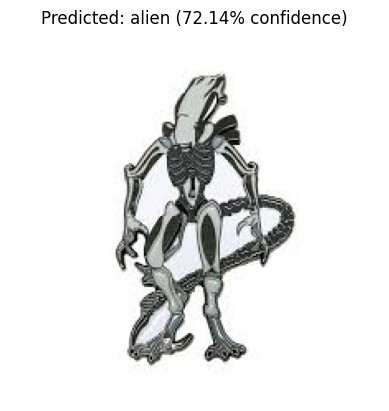

In [10]:
import matplotlib.pyplot as plt

img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.title(f"Predicted: {class_label} ({confidence:.2f}% confidence)")
plt.axis("off")
plt.show()


In [12]:
import os

def predict_images_in_folder(folder_path, model, class_indices):
    results = []
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        class_label, confidence = predict_image(img_path, model, class_indices)
        results.append((img_file, class_label, confidence))
    return results

folder_path = "/content/drive/MyDrive/alien vs predator "
predictions = predict_images_in_folder(folder_path, model, class_indices)

for img_file, label, conf in predictions:
    print(f"Image: {img_file} -> Predicted: {label} ({conf:.2f}% confidence)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Image: Copy of 0.jpg -> Predicted: alien (72.14% confidence)
Image: Copy of 13.jpg -> Predicted: alien (66.75% confidence)
Image: Copy of 1.jpg -> Predicted: predator (99.90% confidence)
Image: Copy of 10.jpg -> Predicted: predator (100.00% confidence)
Image: Copy of 12.jpg -> Predicted: alien (51.59% confidence)
Image: Copy of 11.jpg -> Predicted: predator (100.00% confidence)
Image: Copy of 4.jpg -> Predicted: alien (55.76% confidence)
Image: Copy of 3.jpg -> Predicted: predator (100.00% confidence)
Image: Copy of 0 (1).jpg -> Predicted: predator (100.00% confidence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


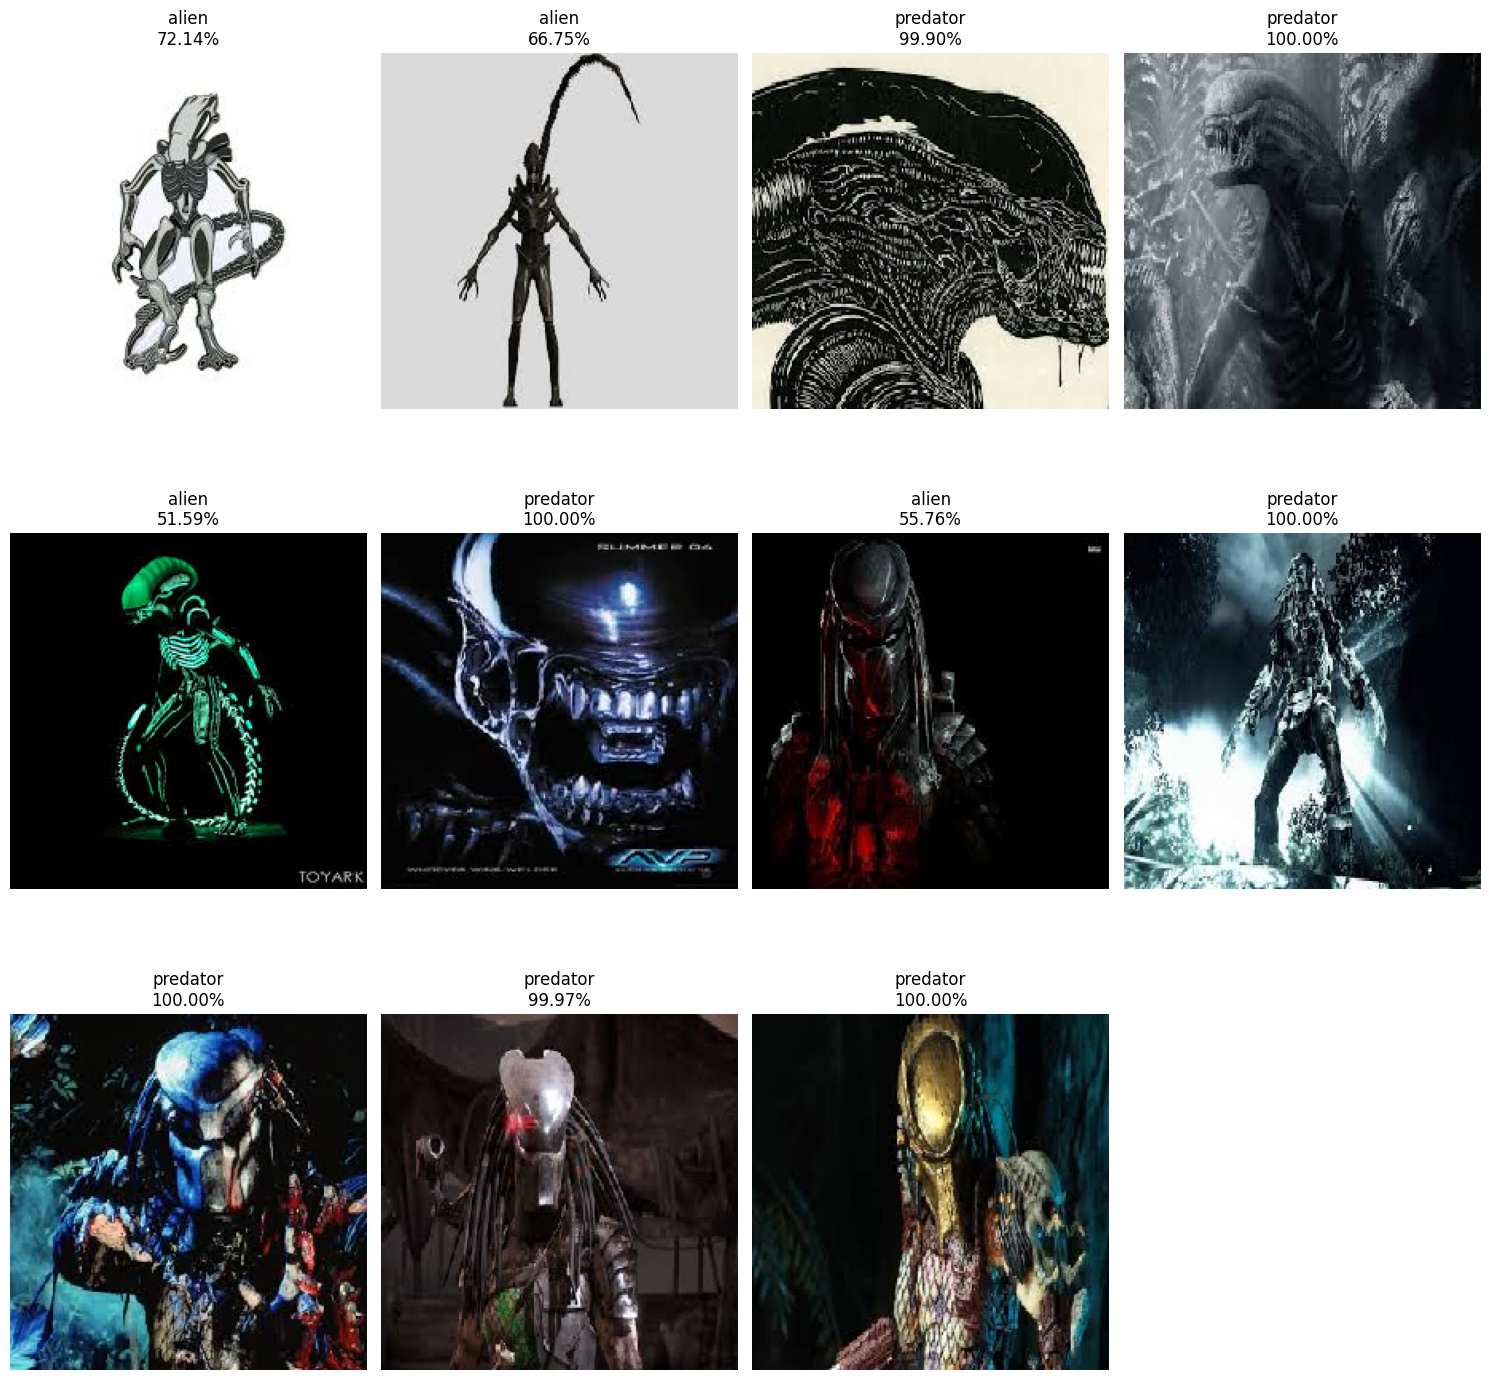

In [15]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def predict_images_and_visualize(folder_path, model, class_indices):
    """
    Predicts the classes of all images in a folder and visualizes them with predictions.
    - folder_path: Path to the folder containing test images.
    - model: The trained model.
    - class_indices: Class label mappings.
    """
    image_files = [f for f in os.listdir(folder_path) if f.endswith((".jpg", ".png", ".jpeg"))]

    plt.figure(figsize=(15, 15))
    for i, img_file in enumerate(image_files):
        img_path = os.path.join(folder_path, img_file)

        # Predict the image class
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        prediction = model.predict(img_array)
        class_idx = np.argmax(prediction, axis=1)[0]
        class_label = list(class_indices.keys())[list(class_indices.values()).index(class_idx)]
        confidence = prediction[0][class_idx] * 100

        # Plot the image with its prediction
        plt.subplot(len(image_files) // 4 + 1, 4, i + 1)
        plt.imshow(img)
        plt.title(f"{class_label}\n{confidence:.2f}%")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
folder_path = "/content/drive/MyDrive/alien vs predator "
predict_images_and_visualize(folder_path, model, val_generator.class_indices)
